# Import Data

In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

train_df = pd.read_csv('../../input/feedback-prize-effectiveness/train.csv')
stack_df = pd.read_csv('../../99_Ensemble/99_v1_02/result/stack_99_v1_02_27.csv')

train_df = train_df[['discourse_id']].merge(stack_df, on='discourse_id', how='left')
print(train_df.shape)
train_df.head()

(36765, 28)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective_0,Adequate_0,Effective_0,label,loss,...,Effective_3,Ineffective_4,Adequate_4,Effective_4,Ineffective_5,Adequate_5,Effective_5,Ineffective,Adequate,Effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.002175,0.152980,0.011512,1,0.085691,...,0.003841,0.013028,0.149802,0.003837,0.013616,0.150725,0.002326,0.044812,0.919796,0.035392
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.009333,0.152729,0.004605,1,0.087332,...,0.006511,0.008662,0.154979,0.003025,0.026612,0.136538,0.003517,0.091948,0.881701,0.026351
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.023451,0.141358,0.001857,1,0.164698,...,0.005504,0.029492,0.135902,0.001273,0.048600,0.115757,0.002310,0.172267,0.812169,0.015564
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.055733,0.109495,0.001439,1,0.420119,...,0.002196,0.032678,0.132563,0.001426,0.056640,0.108651,0.001375,0.236727,0.752566,0.010708
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.041290,0.124674,0.000703,1,0.290297,...,0.001962,0.054301,0.111310,0.001056,0.070796,0.094933,0.000937,0.317408,0.675184,0.007408


# Features

In [2]:
import pickle
import gc

with open("../../input/nlp-word-embeddings/Glove_Embeddings.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
embeddings_index = processed_data['glove_embeddings_index']
print('Word vectors found: {}'.format(len(embeddings_index)))

del processed_data
gc.collect()

Word vectors found: 2196017


0

In [3]:
import nltk
import numpy as np

def sent2vec(text):
    words = nltk.word_tokenize(text)
    words = [w for w in words if w.isalpha()]
    
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            M.append(embeddings_index['unk'])
            continue
    
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    
    return v / np.sqrt((v ** 2).sum())

In [4]:
glove_vec = [sent2vec(x) for x in tqdm(train_df["discourse_text"].values)]
col_list = ['discourse_glove_'+str(i) for i in range(300)]
glove_vec_df = pd.DataFrame(np.array(glove_vec), columns=col_list, index=train_df['discourse_id'].values)
print(f"glove_vec_df: {glove_vec_df.shape}")

100%|██████████| 36765/36765 [00:09<00:00, 3960.13it/s]

glove_vec_df: (36765, 300)


In [5]:
train_df.shape, glove_vec_df.shape

((36765, 28), (36765, 300))

In [6]:
train_df = train_df.merge(glove_vec_df.reset_index(), left_on='discourse_id', right_on='index', how='left')
del train_df['index']; gc.collect()

0

In [7]:
train_df.shape

(36765, 328)

In [12]:
train_df.columns

Index(['discourse_id', 'essay_id', 'discourse_text', 'discourse_type',
       'discourse_effectiveness', 'Ineffective_0', 'Adequate_0', 'Effective_0',
       'label', 'loss',
       ...
       'discourse_glove_290', 'discourse_glove_291', 'discourse_glove_292',
       'discourse_glove_293', 'discourse_glove_294', 'discourse_glove_295',
       'discourse_glove_296', 'discourse_glove_297', 'discourse_glove_298',
       'discourse_glove_299'],
      dtype='object', length=328)

# Data Split

In [8]:
from os.path import join as opj

class args:
    fold_path = '../../00_EDA/00_v2_07/result/'
    num_fold = 5
    
fold_path = args.fold_path
import joblib
print('load folds...')
trn_ids_list = joblib.load(opj(fold_path,f'trn_ids_list.joblib'))
val_ids_list = joblib.load(opj(fold_path,f'val_ids_list.joblib'))

load folds...


# Stacking

In [9]:
import matplotlib.pyplot as plt

def show_feature_importance(model):
    feature_importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'importance':feature_importance, 'features':cols})
    fi_df = fi_df.sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(fi_df)),
            fi_df['importance'].values,
            tick_label=fi_df['features'].values)
    plt.xlabel('importance')
    plt.ylabel('features')
    plt.grid()
    plt.show()

In [10]:
cols = []
for col_name in ['Ineffective','Adequate','Effective']:
    cols += [col for col in train_df.columns if (col.startswith(col_name) and '_' in col)] 
    
num_models = len(cols) // 3
num_models

6

In [11]:
import catboost
params = {
    'random_state':45, 
    'n_estimators':20000,
    'loss_function':'MultiClass',
}

fold0 : CV=0.5756


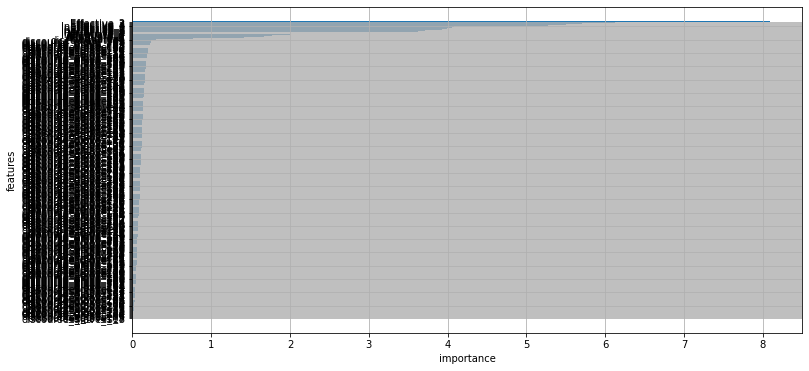

fold1 : CV=0.5917


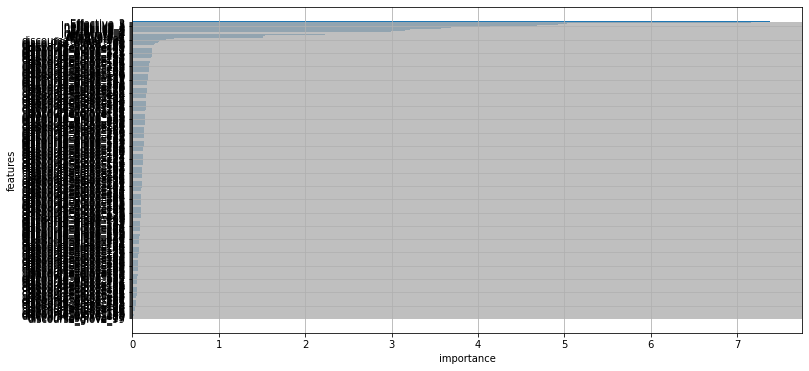

fold2 : CV=0.5770


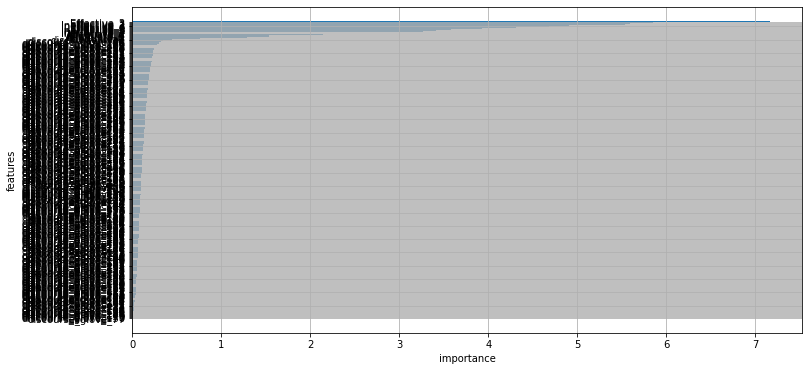

fold3 : CV=0.5928


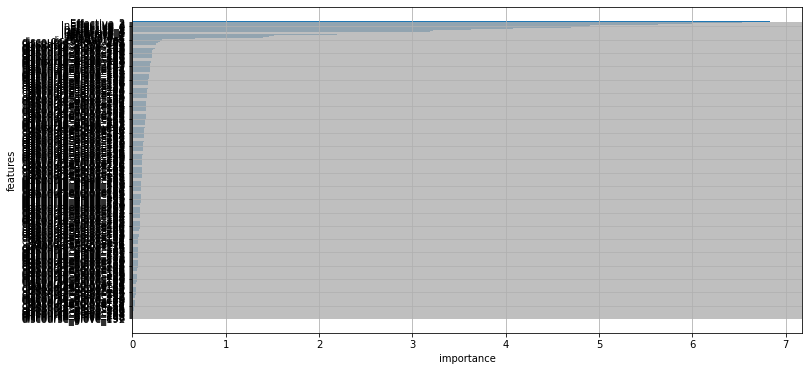

fold4 : CV=0.5824


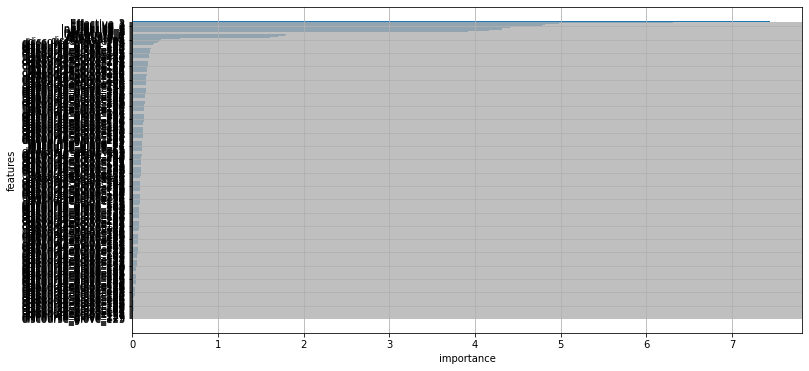

CV=0.5839


In [13]:
from sklearn.metrics import log_loss
import pickle
import os
os.makedirs('./result', exist_ok=True)

cols = ['discourse_type'] + [col for col in train_df.columns if col.startswith('discourse_glove_')] + cols
cat_features = [0]

score_list = []
oof_df = []
for fold in range(args.num_fold):
    trn_df = train_df[train_df['essay_id'].isin(trn_ids_list[fold])].reset_index(drop=True)
    val_df = train_df[train_df['essay_id'].isin(val_ids_list[fold])].reset_index(drop=True)

    pool_trn = catboost.Pool(trn_df[cols].values, label=trn_df['label'].values, cat_features=cat_features)
    pool_val = catboost.Pool(val_df[cols].values, label=val_df['label'].values, cat_features=cat_features)

    model = catboost.CatBoostClassifier(**params)
    model.fit(pool_trn, 
              eval_set=[pool_val], 
              verbose=0, 
              early_stopping_rounds=100,
             )

    pred = model.predict(pool_val, prediction_type='Probability')
    target = val_df['label'].values
    score = log_loss(target, pred, labels=[0,1,2])
    print('fold{} : CV={:.4f}'.format(fold, score))
    score_list.append(score)
    val_df['oof_ineffective'] = pred[:,0]
    val_df['oof_adequate'] = pred[:,1]
    val_df['oof_effective'] = pred[:,2]
    oof_df.append(val_df)
    # save model
    joblib.dump(model, f'./result/cat_fold{fold}.joblib')
    # plot
    show_feature_importance(model)
    
CV = sum(score_list) / len(score_list)
print('CV={:.4f}'.format(CV))

In [14]:
oof_df = pd.concat(oof_df).reset_index(drop=True)
oof_df = train_df[['discourse_id']].merge(oof_df, on='discourse_id', how='left')
oof_df.to_csv(f'./result/oof_cat.csv', index=False)
print(oof_df.shape)
oof_df.head()

(36765, 331)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective_0,Adequate_0,Effective_0,label,loss,...,discourse_glove_293,discourse_glove_294,discourse_glove_295,discourse_glove_296,discourse_glove_297,discourse_glove_298,discourse_glove_299,oof_ineffective,oof_adequate,oof_effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.002175,0.152980,0.011512,1,0.085691,...,-0.033349,0.002727,0.019680,-0.034249,0.011228,0.000507,0.037670,0.046730,0.914602,0.038668
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.009333,0.152729,0.004605,1,0.087332,...,-0.032004,0.014835,0.024092,-0.038885,-0.008356,0.019798,0.023953,0.088890,0.882320,0.028790
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.023451,0.141358,0.001857,1,0.164698,...,-0.036728,0.012231,0.022423,-0.026113,-0.003131,0.011090,0.020836,0.158873,0.820935,0.020192
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.055733,0.109495,0.001439,1,0.420119,...,-0.028899,0.004147,0.001079,-0.056933,-0.001856,0.024004,0.030697,0.259406,0.728599,0.011995
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.041290,0.124674,0.000703,1,0.290297,...,-0.014729,-0.005490,0.017344,-0.029146,0.006806,0.013969,0.019261,0.326266,0.664907,0.008827


In [15]:
cols = [col for col in oof_df.columns if col.startswith('oof_')]

oof_score = log_loss(oof_df['label'].values, oof_df[cols].values, labels=[0,1,2])
print('oof={:.4f}'.format(oof_score))

oof=0.5839
